In [1]:
#Data Analyses Libraries
import pandas as pd                
import numpy as np    
from urllib.request import urlopen
import json
import glob
import os

#Importing Data plotting libraries
import matplotlib.pyplot as plt     
import plotly.express as px       
import plotly.offline as py       
import seaborn as sns             
import plotly.graph_objects as go 
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker
import matplotlib.animation as animation

#Other Miscallaneous Libraries
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML
import matplotlib.colors as mc
import colorsys
from random import randint
import re

#scipy 
from scipy import integrate
from scipy import optimize
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
# Date time
import datetime
from datetime import timedelta

# Ventilator Requirement in Italy

###  Importing The Data

In [2]:
df_italy = pd.read_csv('./dataset/uncover/UNCOVER_v4/UNCOVER/regional_sources/department_of_civil_protection/covid-19-italy-situation-monitoring-by-region.csv')

# Removing columns
df_italy.drop(axis=1, inplace=True, columns=['stato', 'codice_regione', 'lat', 'long', 'totale_positivi', 'isolamento_domiciliare','variazione_totale_positivi', 'nuovi_positivi', 'tamponi', 'note_it', 'note_en','casi_testati'])
print(df_italy.columns)

# Converting headers to English
df_italy.columns = ['date', 'state', 'hospitalized_with_symptom', 'icu', 'hospitalized_total', 'recovered', 'deaths', 'infected']

# Create a list of Italy states/regions
ita_states = list(df_italy['state'].unique())

df_italy

Index(['data', 'denominazione_regione', 'ricoverati_con_sintomi',
       'terapia_intensiva', 'totale_ospedalizzati', 'dimessi_guariti',
       'deceduti', 'totale_casi'],
      dtype='object')


date          state  hospitalized_with_symptom  icu  \
0     2020-02-24 18:00:00        Abruzzo                          0    0   
1     2020-02-24 18:00:00     Basilicata                          0    0   
2     2020-02-24 18:00:00   P.A. Bolzano                          0    0   
3     2020-02-24 18:00:00       Calabria                          0    0   
4     2020-02-24 18:00:00       Campania                          0    0   
...                   ...            ...                        ...  ...   
1822  2020-05-20 17:00:00        Toscana                        178   45   
1823  2020-05-20 17:00:00    P.A. Trento                         39    6   
1824  2020-05-20 17:00:00         Umbria                         25    2   
1825  2020-05-20 17:00:00  Valle d'Aosta                         25    1   
1826  2020-05-20 17:00:00         Veneto                        255   16   

      hospitalized_total  recovered  deaths  infected  
0                      0          0       0         0  
1                      0          0       0         0  
2                      0          0       0         0  
3                      0          0       0         0  
4                      0          0       0         0  
...                  ...        ...     ...       ...  
1822                 223       6867     998      9982  
1823                  45       3787     455      4368  
1824                  27       1287      74      1427  
1825                  26        986     143      1175  
1826                 271      13666    1832     19030  

[1827 rows x 8 columns]

## Visualization

In [3]:
# hospitalized vs time 
fig = px.line(df_italy, x='date', y='hospitalized_total', color='state')
pyo.iplot(fig)

In [4]:
# deaths vs time
fig2 = px.line(df_italy, x='date', y='deaths', color='state')
pyo.iplot(fig2)

In [5]:
# infected vs time
fig3 = px.line(df_italy, x='date', y='infected', color='state')
pyo.iplot(fig3)

## We observe that the region/state of Lombardia has by far the most number of infected people 

# SEIR compartmental model 

In [6]:
# 'y': dependent variables, 't': independent variable (time), 'parameters': parameters of the model
def seir_diff_eqn(y, t, parameters): 
    
    # Parameters to find
    infection_rate = parameters[0]
    recovery_rate = parameters[1]
    exposed_rate = parameters[2]
    
    # SEIR variables
    s = y[0]
    e = y[1]
    i = y[2]
    r = y[3]
    
    # Differential Equations System 
    dSdt = -exposed_rate*s*i
    dEdt = (exposed_rate*s*i) - (infection_rate*e)
    dIdt = (infection_rate*e) - (recovery_rate*i)
    dRdt = recovery_rate*i
    # print(dsdt, dedt, didt, drdt)
    
    return (dSdt, dEdt, dIdt, dRdt)

### The above function ( 'seir_diff_eqn()' ) simply returns the system of differential equations

In [7]:
# FUNCTION - Auxiliar function to find the best parameters
def Fit_SEIR(params_to_fit, t, initial_condition, true_vals):
    # Calculate ODE (ordinary differential equation) solution for possible parameter, return values to each dependent variable:
    # (s, e, i and r)
    
    ODE_SEIR = lambda y,t:seir_diff_eqn(y, t, params_to_fit)
    
    # Calculate ode solution, return values to each
    ode_result = integrate.odeint(func=ODE_SEIR, y0=initial_condition, t=t)
    
    # Return results
    seir_fit= ode_result
       
    # Calculate residual value between predicted VS true
    ## Note: ode_result[0] is S result
    
    residual_i = true_vals[0] - seir_fit[:,2]
    residual_r = true_vals[1] - seir_fit[:,3]

    # Create a np.array of all residual values for both (i) and (r)
    residual = np.concatenate((residual_i, residual_r))
    
    # Return results
    return residual

### The above function ('Fit_SEIR()') finds the best parameters for SEIR

----------------

## SEIR for Lombardia

In [8]:
# Get Lombardia region
region_data = df_italy[df_italy['state'] == 'Lombardia'][['date', 'recovered', 'infected']].reset_index().drop(axis=1, columns=['index'])

In [9]:
region_data

date  recovered  infected
0   2020-02-24 18:00:00          0       172
1   2020-02-25 18:00:00          0       240
2   2020-02-26 18:00:00          0       258
3   2020-02-27 18:00:00         40       403
4   2020-02-28 18:00:00         40       531
..                  ...        ...       ...
82  2020-05-16 17:00:00      41389     84518
83  2020-05-17 17:00:00      41895     84844
84  2020-05-18 17:00:00      42403     85019
85  2020-05-19 17:00:00      42593     85481
86  2020-05-20 17:00:00      43442     85775

[87 rows x 3 columns]

In [10]:
N = 10103969 # Population of Lombardia

### Define Initial Condition (necessary for solving the differential equation)

In [11]:
R_start = region_data.loc[0, 'recovered']/N
I_start = region_data.loc[0, 'infected']/N
E_start = (region_data.loc[6, 'infected'] - region_data.loc[5, 'infected'])/N
S_start = 1 - E_start - I_start

# Set this values as a tuple
initial_conditions = (S_start, E_start, I_start, R_start)

In [12]:
print('Start condition:')
print('s(0): ', initial_conditions[0])
print('e(0): ', initial_conditions[1])
print('i(0): ', initial_conditions[2])
print('r(0): ', initial_conditions[3])

Start condition:
s(0):  0.999946456684497
e(0):  3.652030207139392e-05
i(0):  1.7023013431652454e-05
r(0):  0.0


In [13]:
# Define a time array measure in days
time_period = range(0, len(region_data))

# Create a tuple with the true values in fraction for Infected/Recovered cases (necessary for error measurement)
true_vals = (list(region_data['infected']/N), list(region_data['recovered']/N))

# Input a starting guess for our parameters [infection_rate, recovered rate, exposed rate]
initial_parameters_guess = [0.1, 0.01, 0.1]

### Finding the optimal parameters

In [14]:
optimal_parameters, acceptance = optimize.leastsq(Fit_SEIR, x0=initial_parameters_guess, args=(time_period, 
                                                                initial_conditions, true_vals), ftol=1.49012e-20)

In [15]:
print('\tLombardia')
print('Optimized Infection rate: ', optimal_parameters[0])
print('Optimized Recovered rate: ', optimal_parameters[1])
print('Optimized Exposed rate: ', optimal_parameters[2])

	Lombardia
Optimized Infection rate:  517.3699984973765
Optimized Recovered rate:  0.029339849305285735
Optimized Exposed rate:  0.09405890570512981


### Function to calculate SEIR Model (using 'odeint()') in time as days based on given parameters

In [16]:
def odeint_model(params, t, initial_condition):
    # Create an alias to our ode model to pass guessed params
    ODE_SEIR = lambda y,t:seir_diff_eqn(y, t, params)
    
    
    # Calculate ode solution, return values to each
    ode_result = integrate.odeint(func=ODE_SEIR, y0=initial_condition, t=t)
    
    # Return results
    return ode_result

### Calculate a curve based on optimal parameters

In [17]:
ir = optimal_parameters[0]
rr = optimal_parameters[1]
er = optimal_parameters[2]

seir_fit = odeint_model((ir, rr, er), time_period, initial_conditions)

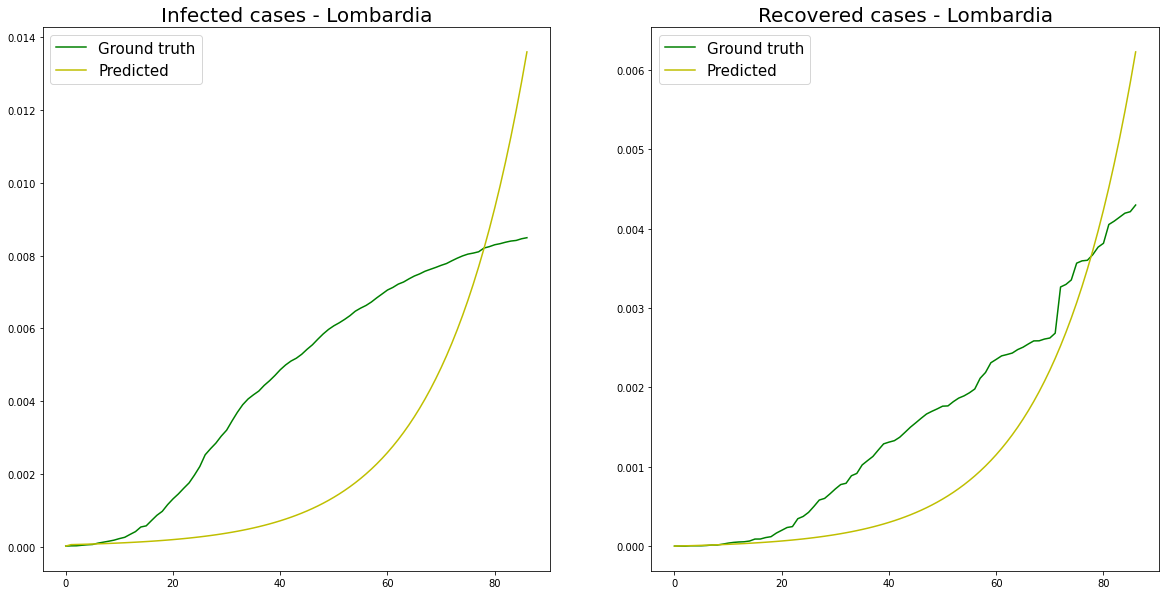

In [18]:
seir_fit# Plot the results for Infected/Recovered
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
## Plot process
axes[0].plot(time_period, true_vals[0], 'g')
axes[0].plot(time_period, seir_fit[:,2], 'y')
axes[0].legend(['Ground truth', 'Predicted'],loc=2, fontsize=15)
axes[0].set_title('Infected cases - Lombardia',fontsize=20)
axes[1].plot(time_period, true_vals[1], 'g')
axes[1].plot(time_period, seir_fit[:,3], 'y')
axes[1].legend(['Ground truth', 'Predicted'],loc=2, fontsize=15)
axes[1].set_title('Recovered cases - Lombardia',fontsize=20);

## We observe that:
### The Infected cases graph is not very accurate but the Recovery rate graph is relatively more accurate.
### This is because SEIR is just a short term mathematical model. This may also be attributed to the fallacies in the assumptions of SIER model, some of which were that the population remains constant during the pandemic (clearly not true in this case) and that people 'must' transmit the virus if they interact with each other. 
### Many possibilities like people interacting while wearing proper protective gear and Asymptomatic people are not accounted for in the model. Nonetheless, it provides some estimation for short term cases.

----------------------------

## SEIR predictions until October for Lombardia¶

In [19]:
# Get prediction full period time in datetime object and the convert to string
datetime_pred = pd.date_range(start="2020-02-24",end="2020-10-31", freq='D')
time_pred = [x.strftime("%Y-%m-%d") for x in datetime_pred]

# Get a list from 01/April to 31/October 
time_pred_range = range(0, len(time_pred))

In [20]:
# Calculate a SEIR prediction 
predictions_future = odeint_model((ir, rr, er), time_pred_range, initial_conditions)

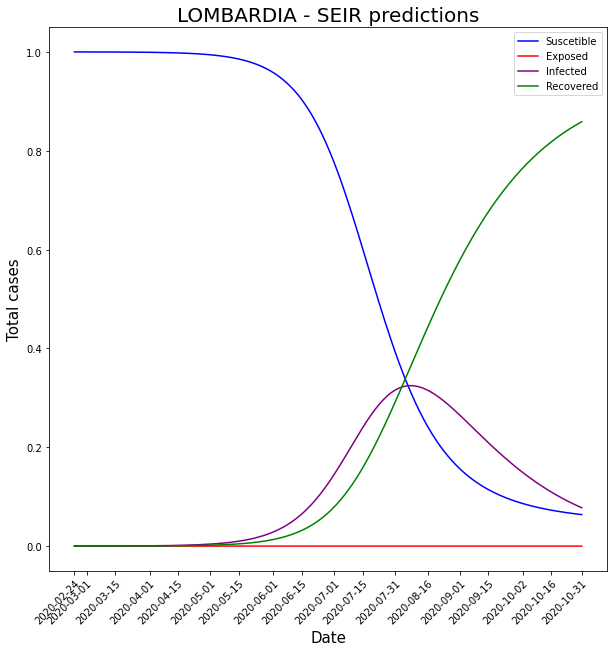

In [21]:
# Plotting the graph
## Label only first/half/last day of every month
time_axis = [time_pred[i] for i in [0,6,20,37,51,67,81,98,112,128,142,158,174,190,204,221,235,250]]
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
## Plot SEIR
sns.lineplot(x=time_pred, y=predictions_future[:,0], ax=axes, color = 'blue')
sns.lineplot(x=time_pred, y=predictions_future[:,1], ax=axes, color = 'red')
sns.lineplot(x=time_pred, y=predictions_future[:,2], ax=axes, color = 'purple')
sns.lineplot(x=time_pred, y=predictions_future[:,3], ax=axes, color = 'green')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.legend(loc=1, labels=['Suscetible', 'Exposed', 'Infected','Recovered'], fontsize=10)
axes.set_title('LOMBARDIA - SEIR predictions', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total cases', fontsize=15)
axes.set_xticks(time_axis);

# Calculate ventilators curve based in SEIR infected curve
## From  [this article](https://www.nsmedicaldevices.com/analysis/coronavirus-ventilators-global-demand/) it is estimated that, of the Covid-19 cases occurring worldwide, about 10% of patients need ventilators.
## So we are assuming that of all the infected people, 10% would require ventilators.

In [22]:
ventilators_future_pred = 0.10*predictions_future[:,2]
# 0.10 for the 10% assumption

## Lombardia Ventilator necessity and infected people curve

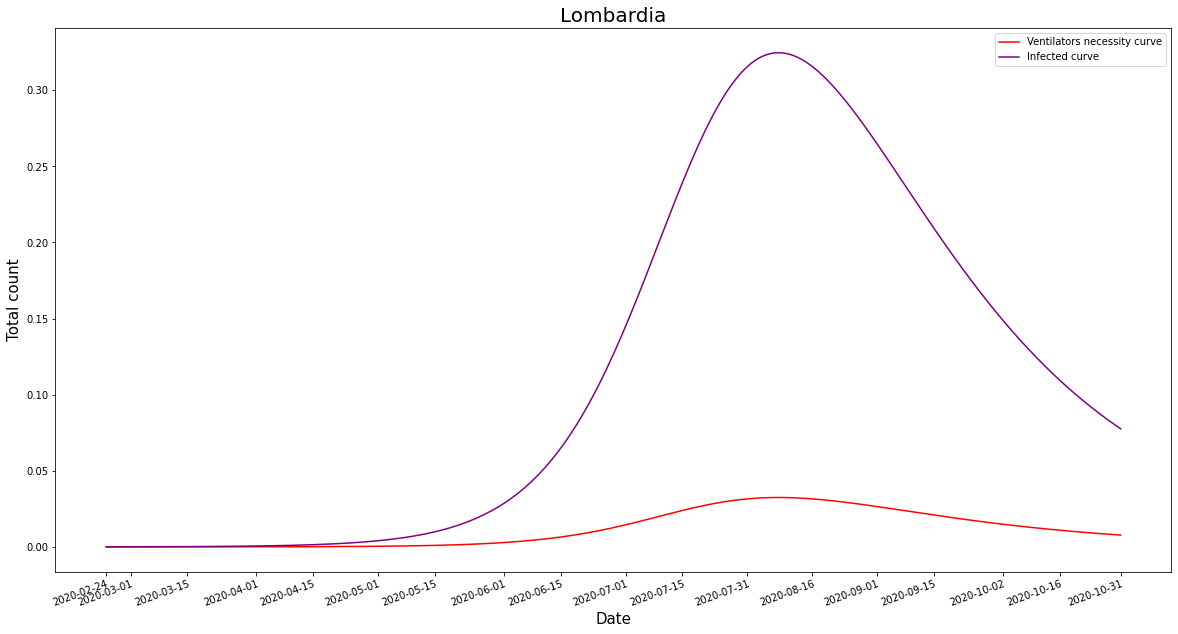

In [23]:
# Plot results
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
## Plot SIR
sns.lineplot(x=time_pred, y=ventilators_future_pred, ax=axes, color = 'red')
sns.lineplot(x=time_pred, y=predictions_future[:,2], ax=axes, color = 'purple')
plt.setp(axes.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")
axes.legend(loc=1, labels=['Ventilators necessity curve','Infected curve'], fontsize=10)
axes.set_title('Lombardia', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total count', fontsize=15)
axes.set_xticks(time_axis);

In [24]:
# Get the maximum curve value and transform to absolute value multiplying by region population
max_vent_necessity = N*max(ventilators_future_pred)
# Show results
print('Lombardia would require: ', int(max_vent_necessity),'ventilators at the peak of the Pandemic')

Lombardia would require:  328037 ventilators at the peak of the Pandemic


### Other risk regions

In [25]:
italy_risk_regions = ['Veneto', 'Piemonte', 'Emilia-Romagna','Puglia','Toscana','Liguria']
# Population for each risk region
pop_states = [4907704.0, 4341375.0, 4467118.0,4031885.0, 3722729.0, 1543127] 

### Finding the  infection rate, recovery rate, exposed rate and  region wise Ventilator curve for the other regions

In [26]:
# The below function returns state_name, infection_rate, recovery_rate, exposed_rate, state_ventilators_curve for 'italy_risk_regions'
def SEIR_region_wise(population_in_states=pop_states,states_in_italy=italy_risk_regions):
    
    # Create an empty tuple
    result = list()
    
    # Loop for each state/region
    for state, population in zip(states_in_italy, population_in_states):
        
        # Get a state/region
        region_data = df_italy[df_italy['state'] == state][['date', 'recovered', 'infected']].reset_index().drop(axis=1, columns=['index'])
        
        N = population
        
        # We search for the starting date such that the recovered and infected have a non-zero value
        for i in range(0, len(region_data)):
            if region_data.loc[i, 'recovered'] != 0.0 and region_data.loc[i, 'infected'] != 0.0:
                index = i
                break
            else:
                index = 0
                
        # Define Initial Condition (necessary for solving the differential equation)
        R_start = region_data.loc[index, 'recovered']/N
        I_start = region_data.loc[index, 'infected']/N
        E_start = (region_data.loc[index + 4, 'infected'] - region_data.loc[index + 3, 'infected'])/N
        S_start = 1 - E_start - I_start
        
        # Tuple for initial condition
        initial_conditions = (S_start, E_start, I_start, R_start)
        
        # Define a time array measure in days, but with values
        time_period = range(index, len(region_data))
        
        # Create a tuple with the true values in fraction for Infected/Recovered cases (necessary for error measurement)
        true_vals = (list(region_data.loc[index:, 'infected']/N), list(region_data.loc[index:, 'recovered']/N))
        
        # Input a starting guess for our parameters [infection_rate, recovered rate, exposed rate]
        initial_parameters_guess = [0.1, 0.01, 0.1]
        
        # Optimization
        optimal_parameters, success = optimize.leastsq(Fit_SEIR,x0=initial_parameters_guess, args=(time_period, initial_conditions, true_vals), ftol=1.49012e-15,  maxfev=10000)
        
        # Get calculated parameters
        ir = optimal_parameters[0]
        rr = optimal_parameters[1]
        er = optimal_parameters[2]
        
        # Get prediction full period time in datetime object and the convert to string
        datetime_pred = pd.date_range(start="2020-02-24",end="2020-10-31", freq='D')
        time_pred = [x.strftime("%Y-%m-%d") for x in datetime_pred]
        
        # Get a list from 01/April to 31/July 
        time_pred_range = range(0, len(time_pred))
        
        # Calculate a SEIR prediction 
        predictions_future = odeint_model((ir, rr, er), time_pred_range, initial_conditions)
        
        # Generate tuple result for this state
        state_result = (state, ir, rr, er, 0.10*predictions_future[:,2])
        
        # Append to the region_wise list
        result.append(state_result)
    # Return
    return result    

# Region wise results
risk_regions_results = SEIR_region_wise()

## Italy region-wise Ventilator Prediction

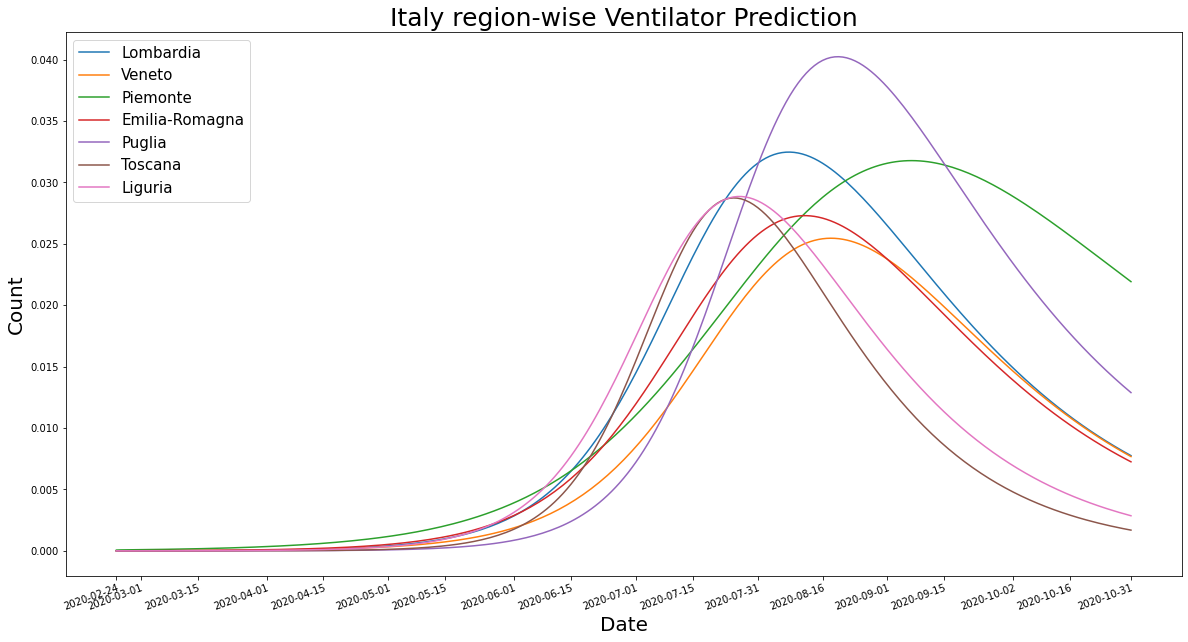

In [27]:
regions = ['Lombardia', 'Veneto', 'Piemonte', 'Emilia-Romagna','Puglia','Toscana','Liguria']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.lineplot(x=time_pred, y=ventilators_future_pred, ax=axes)

## Plot for the other 6 regions
for state in risk_regions_results:
    state_name = state[0]
    vent_curve = state[4]
    sns.lineplot(x=time_pred, y=vent_curve, ax=axes)
plt.setp(axes.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")
axes.legend(loc=0, labels=regions, fontsize=15)

axes.set_title('Italy region-wise Ventilator Prediction', fontsize=25)
axes.set_xlabel('Date', fontsize=20)
axes.set_ylabel('Count', fontsize=20)
axes.set_xticks(time_axis);

### From the above graph we observe that even though Puglia had the lowest cases and ventilator requirements initially as compared to the other regions shown in the graphs, it requires more ventilators than any other region around August 2020.

### Printing region wise and total Ventilator counts

In [28]:
total_ventilators_req = 0
print('\n\tHIGH RISK REGIONS\n')
print('1   Lombardia ')
print('Number of Ventilators required: ', int(max_vent_necessity),'\n')

total_ventilators_req += int(max_vent_necessity)
c=2
for i, N in zip(risk_regions_results, pop_states):
    print(c,' ',i[0])
    print('Number of Ventilators required: ', int(max(i[4]*N)),'\n')
    total_ventilators_req += int(max(i[4]*N))
    c=c+1
print('Total: ',total_ventilators_req)


	HIGH RISK REGIONS

1   Lombardia 
Number of Ventilators required:  328037 

2   Veneto
Number of Ventilators required:  124924 

3   Piemonte
Number of Ventilators required:  137935 

4   Emilia-Romagna
Number of Ventilators required:  121915 

5   Puglia
Number of Ventilators required:  162208 

6   Toscana
Number of Ventilators required:  106981 

7   Liguria
Number of Ventilators required:  44520 

Total:  1026520


## In total Italy would need 1,026,520 Ventilators for just these 7 regions

---------------------------

--------------------------

# Ventilator Requirement in India

### Differential equations

In [29]:
def seir_model_ode(y, t, params): 
    '''
    Arguments:
    - y: dependent variables
    - t: independent variable (time)
    - params: Model params
    '''
    # Parameters to find
    infection_rate = params[0]
    recovery_rate = params[1]
    exposed_rate = params[2]
    
    # Y variables
    s = y[0]
    e = y[1]
    i = y[2]
    r = y[3]
    
    # SEIR EDO System 
    dsdt = -exposed_rate*s*i
    dedt = (exposed_rate*s*i) - (infection_rate*e)
    didt = (infection_rate*e) - (recovery_rate*i)
    drdt = recovery_rate*i
    
    # Return our system
    return (dsdt, dedt, didt, drdt)

### Solution to differential equations

In [30]:
# FUNCTION - Calculate SEIR Model in t (time as days) based on given parameters
def calculate_seir_model(params, t, initial):
    # Create an alias to our ode model to pass guessed params
    seir_optim = lambda y,t:seir_model_ode(y, t, params)
    
    # Calculate ode solution, return values to each
    ode_result = integrate.odeint(func=seir_optim, y0=initial, t=t)
    
    # Return results
    return ode_result

### Loss Function 

In [31]:
# FUNCTION -  function to find the best parameters
def fit_seir_model(params_to_fit, t, initial_condition, inf_rec_true):
    # Calculate ODE solution for possible parameter, return values to each dependent variable:
    # (s, e, i and r)
    fit_result = calculate_seir_model(params_to_fit, t, initial_condition)
    
    # Calculate residual value between predicted VS true
    ## Note: ode_result[0] is S result
    residual_i = inf_rec_true[0] - fit_result[:,2]
    residual_r = inf_rec_true[1] - fit_result[:,3]

    # Create a np.array of all residual values for both (i) and (r)
    residual = np.concatenate((residual_i, residual_r))
    
    # Return results
    return residual

### Dataset Links
[Covid19India](https://api.covid19india.org/)
#### India's Time Series Data
#### Csv File Used - case_time_series.csv

In [32]:
df_india_status=pd.read_csv('./dataset/case_time_series.csv')

In [33]:
columns=['Date_YMD','Daily Confirmed','Daily Deceased','Daily Recovered','Total Confirmed',
         'Total Deceased','Total Recovered']
df_india_status=df_india_status[columns]
df_india_status.columns=['date','Daily Confirmed','Daily Deceased','Daily Recovered','infected','deaths','recovered']

In [34]:
df_india_status['active']=df_india_status['infected']-df_india_status['recovered']

In [35]:
df_india_status

date  Daily Confirmed  Daily Deceased  Daily Recovered  infected  \
0    2020-01-30                1               0                0         1   
1    2020-01-31                0               0                0         1   
2    2020-02-01                0               0                0         1   
3    2020-02-02                1               0                0         2   
4    2020-02-03                1               0                0         3   
..          ...              ...             ...              ...       ...   
274  2020-10-30            48117             550            59005   8136089   
275  2020-10-31            47228             469            58682   8183317   
276  2020-11-01            45928             491            53312   8229245   
277  2020-11-02            37592             498            58524   8266837   
278  2020-11-03            46033             510            53328   8312870   

     deaths  recovered  active  
0         0          0       1  
1         0          0       1  
2         0          0       1  
3         0          0       2  
4         0          0       3  
..      ...        ...     ...  
274  121090    7430744  705345  
275  121559    7489426  693891  
276  122050    7542738  686507  
277  122548    7601262  665575  
278  123058    7654590  658280  

[279 rows x 8 columns]

## Let's have a look at the cumulative confirmed cases,active cases,deaths and recoveries 

In [36]:
# Define figure and plot!
fig = px.line(df_india_status, x='date', y='infected')
pyo.iplot(fig)

In [37]:
# Define figure and plot!
fig = px.line(df_india_status, x='date', y='active')
pyo.iplot(fig)

In [38]:
# Define figure and plot!
fig = px.line(df_india_status, x='date', y='deaths')
pyo.iplot(fig)

In [39]:
# Define figure and plot!
fig = px.line(df_india_status, x='date', y='recovered')
pyo.iplot(fig)

## Daily Variations 

In [40]:
# Define figure and plot!
fig = px.line(df_india_status, x='date', y='Daily Confirmed')
pyo.iplot(fig)

In [41]:
# Define figure and plot!
fig = px.line(df_india_status, x='date', y='Daily Deceased')
pyo.iplot(fig)

In [42]:
N =  1380004385 #India's population

### Setting initial parameters for S,E,I,R

In [43]:
train_data=df_india_status[df_india_status['date']>='2020-05-19'].reset_index(drop=True)
train_data

date  Daily Confirmed  Daily Deceased  Daily Recovered  infected  \
0    2020-05-19             6154             146             3032    106480   
1    2020-05-20             5720             134             3113    112200   
2    2020-05-21             6023             148             3131    118223   
3    2020-05-22             6536             142             3280    124759   
4    2020-05-23             6667             142             2576    131424   
..          ...              ...             ...              ...       ...   
164  2020-10-30            48117             550            59005   8136089   
165  2020-10-31            47228             469            58682   8183317   
166  2020-11-01            45928             491            53312   8229245   
167  2020-11-02            37592             498            58524   8266837   
168  2020-11-03            46033             510            53328   8312870   

     deaths  recovered  active  
0      3301      42309   64171  
1      3435      45422   66778  
2      3583      48553   69670  
3      3725      51833   72926  
4      3867      54409   77015  
..      ...        ...     ...  
164  121090    7430744  705345  
165  121559    7489426  693891  
166  122050    7542738  686507  
167  122548    7601262  665575  
168  123058    7654590  658280  

[169 rows x 8 columns]

In [44]:
# Define Initial Condition (necessary for ODE solve)
R_init =  train_data.loc[0, 'recovered']/N
I_init = train_data.loc[0, 'active']/N
E_init = (train_data.loc[5,'active'] - train_data.loc[4, 'active'])/N
S_init = 1 - E_init - I_init
# Set this values as a tuple
ic = (S_init, E_init, I_init, R_init)

In [45]:
print('Start condition:')
print('s(0): ', ic[0])
print('e(0): ', ic[1])
print('i(0): ', ic[2])
print('r(0): ', ic[3])

Start condition:
s(0):  0.9999507255188903
e(0):  2.7739042292970687e-06
i(0):  4.650057688041332e-05
r(0):  3.0658598233367205e-05


In [46]:
# Time array 
time_arr = range(0, len(train_data))

# Create a tuple for true values
inf_rec_true = (list((train_data['active'])/N), list(train_data['recovered']/N))

# Initial guess for params
params_initial = [0.5, 0.01, 0.01]

### Minimize the residuals using Least Squares

In [47]:
optimal_params, success = optimize.leastsq(fit_seir_model,x0=params_initial,args=(time_arr, ic, inf_rec_true),ftol=1.49012e-20)

In [48]:
print('Optimize infection rate: ', optimal_params[0])
print('Optimize recovered rate: ', optimal_params[1])
print('Optimize exposed rate: ', optimal_params[2])

Optimize infection rate:  16365.514036660787
Optimize recovered rate:  0.13519967907284097
Optimize exposed rate:  0.15227739847811908


In [49]:
# Get the optimal parameters
ir = optimal_params[0]
rr = optimal_params[1]
er = optimal_params[2]

In [50]:
# Calculate a curve based on those parameters
y_pred = calculate_seir_model((ir, rr, er), time_arr, ic)

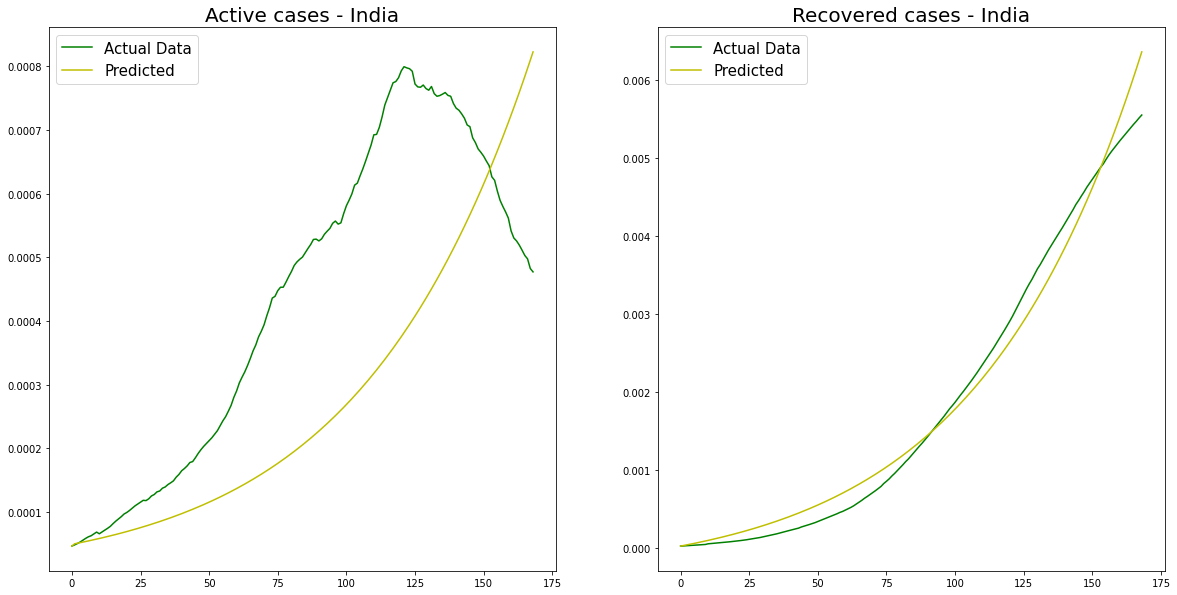

In [51]:
# Plot the results for Active/Recovered
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
## Plot process
axes[0].plot(time_arr, inf_rec_true[0], 'g')
axes[0].plot(time_arr, y_pred[:,2], 'y')
axes[0].legend(['Actual Data', 'Predicted'],loc=2, fontsize=15)
axes[0].set_title('Active cases - India',fontsize=20)
axes[1].plot(time_arr, inf_rec_true[1], 'g')
axes[1].plot(time_arr, y_pred[:,3], 'y')
axes[1].legend(['Actual Data', 'Predicted'],loc=2, fontsize=15)
axes[1].set_title('Recovered cases - India',fontsize=20);

In [52]:
from sklearn.metrics import r2_score

In [53]:
print('Accuracy for Active Cases :',r2_score(inf_rec_true[0],y_pred[:,2]))

Accuracy for Active Cases : 0.14927421872906255


In [54]:
print('Accuracy for Recovered Cases :',r2_score(inf_rec_true[1],y_pred[:,3]))

Accuracy for Recovered Cases : 0.9833270068148886


In [55]:
# Get prediction full period time in datetime object and the convert to string
datetime_pred = pd.date_range(start="2020-02-24",end="2020-12-31", freq='D')
time_pred = [x.strftime("%Y-%m-%d") for x in datetime_pred]

# Get a list from Feb to December
time_pred_range = range(0, len(time_pred))

In [56]:
future_pred = calculate_seir_model((ir, rr, er), time_pred_range, ic)

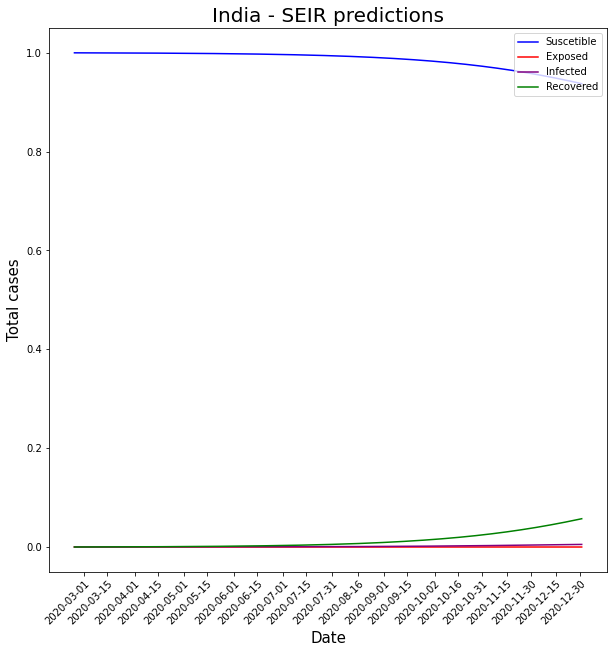

In [57]:
# Plot results

time_axis = [time_pred[i] for i in [6,20,37,51,67,81,98,112,128,142,158,174,190,204,221,235,250,265,280,295,310]]  # Day Number since February 24
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
## Plot SEIR
sns.lineplot(x=time_pred, y=future_pred[:,0], ax=axes, color = 'blue')
sns.lineplot(x=time_pred, y=future_pred[:,1], ax=axes, color = 'red')
sns.lineplot(x=time_pred, y=future_pred[:,2], ax=axes, color = 'purple')
sns.lineplot(x=time_pred, y=future_pred[:,3], ax=axes, color = 'green')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.legend(loc=1, labels=['Suscetible', 'Exposed', 'Infected','Recovered'], fontsize=10)
axes.set_title('India - SEIR predictions', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total cases', fontsize=15)
axes.set_xticks(time_axis);

### Now That We have predicted the number of infected cases till December, we will see how many ventilators India will require throughout the time .
### We will do this by using the factual data that about 10-15% (13%) of all infected people in India require ventilators

In [58]:
# Calculate ventilators curve based in SEIR infected curve
future_pred_vent = 0.13*future_pred[:,2]*N    

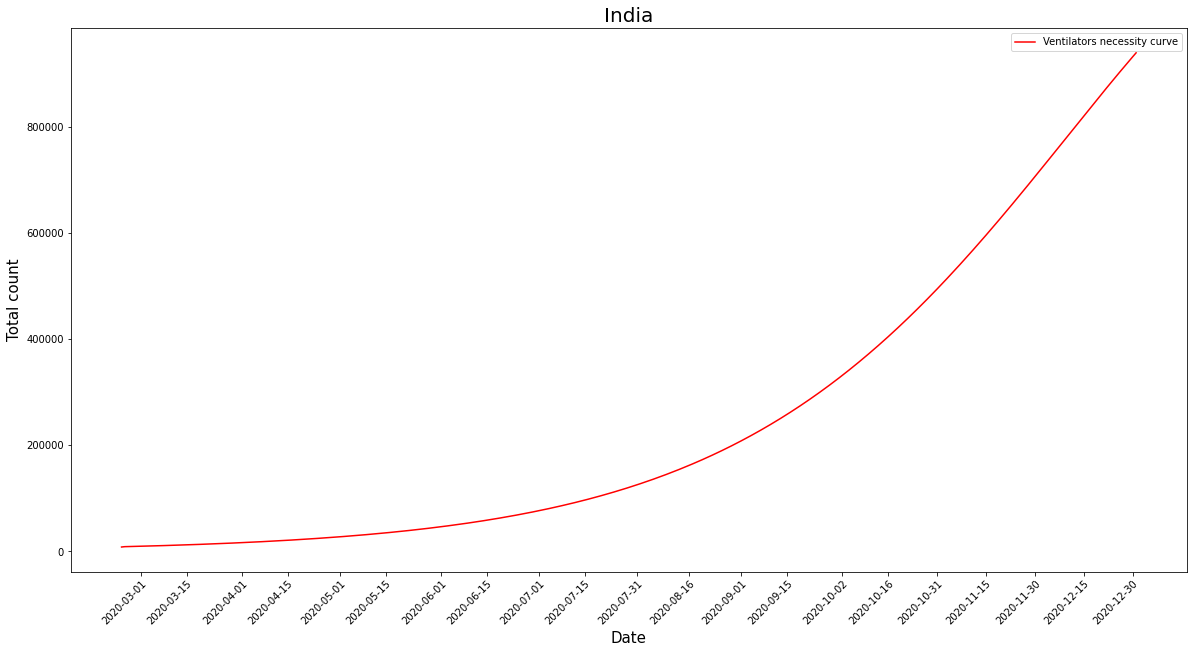

In [59]:
# Plot results
## Define plot object
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
## Plot SIR
sns.lineplot(x=time_pred, y=future_pred_vent, ax=axes, color = 'red')
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.legend(loc=1, labels=['Ventilators necessity curve'], fontsize=10)
axes.set_title('India', fontsize=20)
axes.set_xlabel('Date', fontsize=15)
axes.set_ylabel('Total count', fontsize=15)
axes.set_xticks(time_axis);

In [60]:
# Get the maximum curve value and transform to absolute value multiplying by region population
max_vent_necessity =max(future_pred_vent)
# Show results
print('India would need: ', int(max_vent_necessity),'ventilators.')

India would need:  940102 ventilators.


### As we can see, this is a huge number of ventilators. It should be kept in mind that these many ventilators are needed to cater to the needs of each individual who requires it. So it is the ideal case scenario for any country. 
### Now, we will see an alternate approach using reproduction Number and use H(Hospitalized),C(Critical),D(Deaths) in addition to S,E,I,R

In [61]:
train_data=df_india_status[df_india_status['date']<='2020-09-15']
valid_data=df_india_status[ (df_india_status['date']>'2020-09-15')]
test_data=df_india_status[df_india_status['date']>'2020-09-15']

In [62]:
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S


# Exposed 
def dE_dt(S, E, I, R_t, t_inf, t_inc):
    return (R_t / t_inf) * I * S - (E / t_inc)


# Infected 
def dI_dt(I, E, t_inc, t_inf):
    return (E / t_inc) - (I / t_inf)


# Hospialized 
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a):
    return ((1 - m_a) * (I / t_inf)) + ((1 - f_a) * C / t_crit) - (H / t_hosp)


# Critical 
def dC_dt(H, C, t_hosp, t_crit, c_a):
    return (c_a * H / t_hosp) - (C / t_crit)


# Recovered 
def dR_dt(I, H, t_inf, t_hosp, m_a, c_a):
    return (m_a * I / t_inf) + (1 - c_a) * (H / t_hosp)


# Deaths 
def dD_dt(C, t_crit, f_a):
    return f_a * C / t_crit


def SEIR_HCD_model(t, y, R_t, t_inc=2.9, t_inf=5.2, t_hosp=4, t_crit=14, m_a=0.8, c_a=0.1, f_a=0.3):
    """

    t: Time step for solve_ivp
    y: Previous solution or initial values
    R_t: Reproduction number
    t_inc: Average incubation period. Default 5.2 days
    t_inf: Average infectious period. Default 2.9 days
    t_hosp: Average time a patient is in hospital before either recovering or becoming critical. Default 4 days
    t_crit: Average time a patient is in a critical state (either recover or die). Default 14 days
    m_a: Fraction of infections that are asymptomatic or mild. Default 0.8
    c_a: Fraction of severe cases that turn critical. Default 0.1
    f_a: Fraction of critical cases that are fatal. Default 0.3
    return:
    """
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t
        
    S, E, I, R, H, C, D = y
    
    S_out = dS_dt(S, I, reprod, t_inf)
    E_out = dE_dt(S, E, I, reprod, t_inf, t_inc)
    I_out = dI_dt(I, E, t_inc, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, m_a, c_a)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a)
    C_out = dC_dt(H, C, t_hosp, t_crit, c_a)
    D_out = dD_dt(C, t_crit, f_a)
    return [S_out, E_out, I_out, R_out, H_out, C_out, D_out]

In [63]:
def plot_graph(solution, title):
    sus, exp, inf, rec, hosp, crit, death = solution.y
    
    cases = inf + rec + hosp + crit + death

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle(title)
    
    ax1.plot(sus, 'tab:blue', label='Susceptible');
    ax1.plot(exp, 'tab:orange', label='Exposed');
    ax1.plot(inf, 'tab:red', label='Infected');
    ax1.plot(rec, 'tab:green', label='Recovered');
    ax1.plot(hosp, 'tab:purple', label='Hospitalised');
    ax1.plot(crit, 'tab:brown', label='Critical');
    ax1.plot(death, 'tab:cyan', label='Deceased');
    
    ax1.set_xlabel("Days", fontsize=10);
    ax1.set_ylabel("Fraction of population", fontsize=10);
    ax1.legend(loc='best');
    
    ax2.plot(cases, 'tab:red', label='Cases');    
    ax2.set_xlabel("Days", fontsize=10);
    ax2.set_ylabel("Fraction of population (Cases)", fontsize=10, color='tab:red');
    
    ax3 = ax2.twinx()
    ax3.plot(death, 'tab:cyan', label='Deceased');    
    ax3.set_xlabel("Days", fontsize=10);
    ax3.set_ylabel("Fraction of population (Fatalities)", fontsize=10, color='tab:cyan');

###  Hypothetical Model of SEIR HCD Using the differential Equations
#### Model Where the reproduction Number stays constant

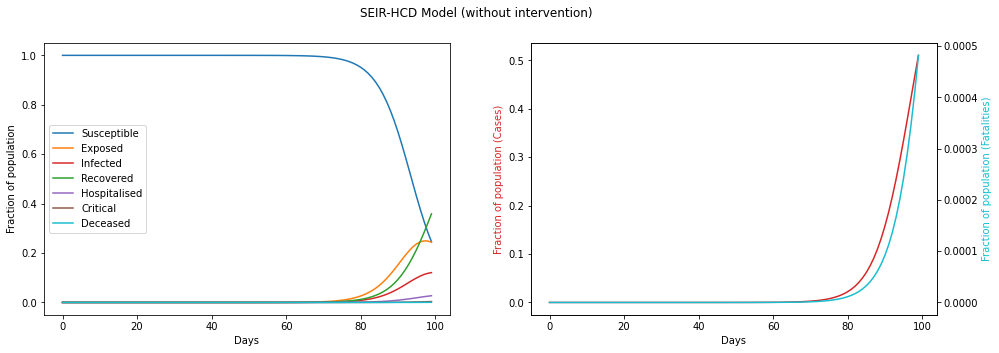

In [64]:
N =  1380004385 #India's population
n_infected = 1
max_days = 100

# State at time = 0 for SEIR_HCD model
# The numbers correspond to the number of people in each of the SEIRHCD compartments
initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]

R_0 = 3.6
t_inc = 5.6
t_inf = 2.9
t_hosp = 4
t_crit = 14
m_a = 0.8
c_a = 0.1
f_a = 0.3

args = (R_0, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

solution = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

plot_graph(solution, 'SEIR-HCD Model (without intervention)')

#### Model Where the Reproduction Number decreases after a fixed number of days

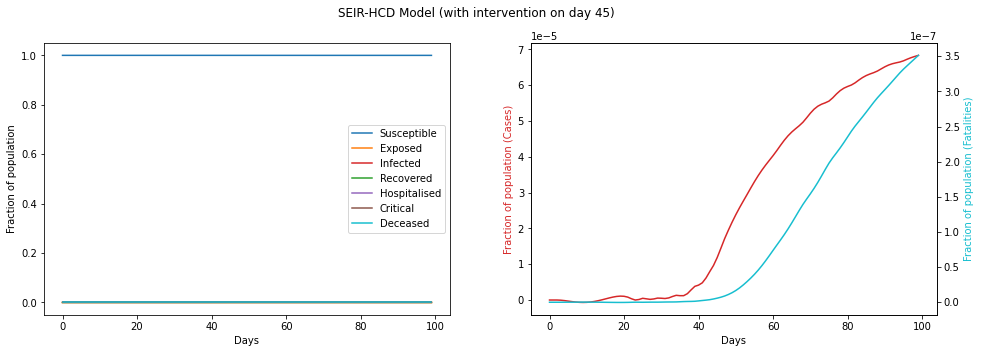

In [65]:
R_0 = 3.6 # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention
intervention_day = 45

def time_varying_reproduction(t):
    if t > intervention_day:
        return R_t
    else:
        return R_0
    
args = (time_varying_reproduction, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

solution2 = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

plot_graph(solution2, f'SEIR-HCD Model (with intervention on day {intervention_day})')

### Comparison between the 2 Hypothetical models 

In [66]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

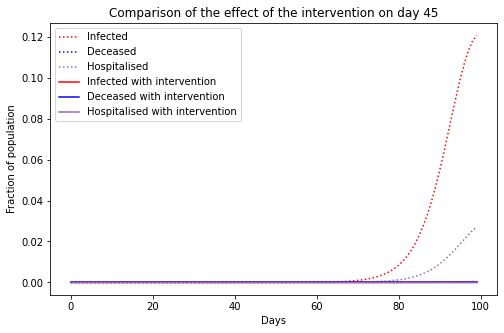

In [67]:
sus, exp, inf, rec, hosp, crit, deaths = solution.y
sus2, exp2, inf2, rec2, hosp2, crit2, deaths2 = solution2.y

f = plt.figure(figsize=(8,5)) 
# plt.plot(exp, 'tab:orange', label='Exposed', linestyle=':');
plt.plot(inf, 'r', label='Infected', linestyle=':');
plt.plot(deaths, 'b', label='Deceased', linestyle=':');
plt.plot(hosp, 'tab:purple', label='Hospitalised', linestyle=':');
# plt.plot(exp2, 'tab:orange', label='Exposed with intervention');
plt.plot(inf2, 'r', label='Infected with intervention');
plt.plot(deaths2, 'b', label='Deceased with intervention');
plt.plot(hosp2, 'tab:purple', label='Hospitalised with intervention');

plt.title(f'Comparison of the effect of the intervention on day {intervention_day}')
plt.xlabel("Days", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best');

In [68]:
OPTIM_DAYS = 21  # Number of days to use for the optimisation evaluation

### Model for a constant reproduction number

In [69]:
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, t_hosp, t_crit, m, c, f = params
    N = population
    n_infected = data['active'].iloc[0]
    max_days = len(data) + forecast_days
    initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
    args = (R_0, 5.6, 2.9, t_hosp, t_crit, m, c, f)
               
    sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred_cases = np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population
    y_true_cases = data['active'].values
    y_pred_fat = np.clip(deaths, 0, np.inf) * population
    y_true_fat = data['deaths'].values
    
    optim_days = min(OPTIM_DAYS, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

### Model for a Time Decaying Reproduction Number

In [70]:
# Use a Hill decayed reproduction number
def eval_model_decay(params, data, population, return_solution=False, forecast_days=0):
    R_0, t_hosp, t_crit, m, c, f, k, L = params  
    N = population
    n_infected = data['active'].iloc[0]
    max_days = len(data) + forecast_days
    
    # https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions   
    # Hill decay. Initial values: R_0=2.2, k=2, L=50
    def time_varying_reproduction(t): 
        return R_0 / (1 + (t/L)**k)
    
    initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
    args = (time_varying_reproduction, 5.6, 2.9, t_hosp, t_crit, m, c, f)
            
    sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred_cases = np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population
    y_true_cases = data['active'].values
    y_pred_fat = np.clip(deaths, 0, np.inf) * population
    y_true_fat = data['deaths'].values
    
    optim_days = min(OPTIM_DAYS, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final


In [71]:
def use_last_value(train_data, valid_data, test_data):
    lv = train_data[['active', 'deaths']].iloc[-1].values
    
    forecast_ids = test_data['ForecastId']
    submission.loc[forecast_ids, ['active', 'deaths']] = lv
    
    if valid_data is not None:
        y_pred_valid = np.ones((len(valid_data), 2)) * lv.reshape(1, 2)
        y_true_valid = valid_data[['active', 'deaths']]

        msle_cases = mean_squared_log_error(y_true_valid['active'], y_pred_valid[:, 0])
        msle_fat = mean_squared_log_error(y_true_valid['deaths'], y_pred_valid[:, 1])
        msle_final = np.mean([msle_cases, msle_fat])

        return msle_final

In [72]:
def plot_model_results(y_pred, train_data, valid_data=None):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
    fig2,ax3=plt.subplots(1,figsize=(10,5))
    ax1.set_title('Active Cases')
    ax2.set_title('Deaths')
    ax3.set_title('Ventilators Required')
    
    train_data['active'].plot(label='Active Cases (train)', color='g', ax=ax1)
    y_pred.loc[train_data.index, 'active'].plot(label='Modeled Cases', color='r', ax=ax1)
    ax1R = y_pred['R'].plot(label='Reproduction number', color='c', linestyle='-', secondary_y=True, ax=ax1)
    ax1R.set_ylabel("Reproduction number", fontsize=10, color='c');
        
    train_data['deaths'].plot(label='Deaths (train)', color='g', ax=ax2)
    y_pred.loc[train_data.index, 'deaths'].plot(label='Modeled Deaths', color='r', ax=ax2)
    
   
    y_pred.loc[train_data.index, 'ventilators'].plot(label='Ventilators Req', color='r', ax=ax3)
    
    
    
    if valid_data is not None:
        valid_data['active'].plot(label='Active Cases (valid)', color='g', linestyle=':', ax=ax1)
        valid_data['deaths'].plot(label='Deaths (valid)', color='g', linestyle=':', ax=ax2)
        y_pred.loc[valid_data.index, 'active'].plot(label='Active Cases (forecast)', color='r', linestyle=':', ax=ax1)
        y_pred.loc[valid_data.index, 'deaths'].plot(label='Modeled Deaths (forecast)', color='r', linestyle=':', ax=ax2)
    else:
        y_pred.loc[:, 'active'].plot(label='Active Cases (forecast)', color='r', linestyle=':', ax=ax1)
        y_pred.loc[:, 'deaths'].plot(label='Modeled Deaths(forecast)', color='r', linestyle=':', ax=ax2)
        
    ax1.legend(loc='best')

### Applying the model on our train and validation data

In [73]:
def fit_model(population,
                     initial_guess=[3.6, 4, 14, 0.8, 0.1, 0.3, 2, 50],
                     bounds=((1, 20), # R bounds
                             (0.5, 10), (2, 20), # transition time param bounds
                             (0.5, 1), (0, 1), (0, 1), (1, 5), (1, 100)), # fraction time param bounds
                     make_plot=True):
        
    
        
    cases_per_million = train_data['active'].max() * 10**6 / population
    n_infected = train_data['active'].iloc[0]
        
    if cases_per_million < 1:
        return use_last_value(train_data, valid_data, test_data)
                
    res_const = minimize(eval_model_const, initial_guess[:-2], bounds=bounds[:-2],
                         args=(train_data, population, False),
                         method='L-BFGS-B')    # For Constant Reproduction Number
    
    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')    # For Decaying Reproduction Number
    
    dates_all = train_data.index.append(test_data.index)
    dates_val = train_data.index.append(valid_data.index)
    
    
    # If using a constant R number is better, use that model
    if res_const.fun < res_decay.fun:
        msle, sol = eval_model_const(res_const.x, train_data, population, True, len(test_data))
        res = res_const
        R_t = pd.Series([res_const.x[0]] * len(dates_val), dates_val)
    else:
        msle, sol = eval_model_decay(res_decay.x, train_data, population, True, len(test_data))
        res = res_decay
        
        # Calculate the R_t values
        t = np.arange(len(dates_val))
        R_0, t_hosp, t_crit, m, c, f, k, L = res.x  
        R_t = pd.Series(R_0 / (1 + (t/L)**k), dates_val)
        
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred = pd.DataFrame({
        'active': np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population,
        'deaths': np.clip(deaths, 0, np.inf) * population,
        'ventilators':np.clip(hosp + crit,0,np.inf)*population,
        'R': R_t,
    }, index=dates_all)
    
    y_pred_valid = y_pred.iloc[len(train_data): len(train_data)+len(valid_data)]
    y_pred_test = y_pred.iloc[len(train_data):]
    y_true_valid = valid_data[['active', 'deaths']]
        
    valid_msle_cases = mean_squared_log_error(y_true_valid['active'], y_pred_valid['active'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['deaths'], y_pred_valid['deaths'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    
    if make_plot:
        print(f'Validation MSLE: {valid_msle:0.5f}')
        print(f'R: {res.x[0]:0.3f}, t_hosp: {res.x[1]:0.3f}, t_crit: {res.x[2]:0.3f}, '
              f'm: {res.x[3]:0.3f}, c: {res.x[4]:0.3f}, f: {res.x[5]:0.3f}')
        plot_model_results(y_pred, train_data, valid_data)
        
   
    
    return valid_msle

In [74]:
N =  1380004385 #India's population

Validation MSLE: 0.04593
R: 3.963, t_hosp: 4.059, t_crit: 14.079, m: 0.677, c: 0.802, f: 0.105


0.04592756306614698

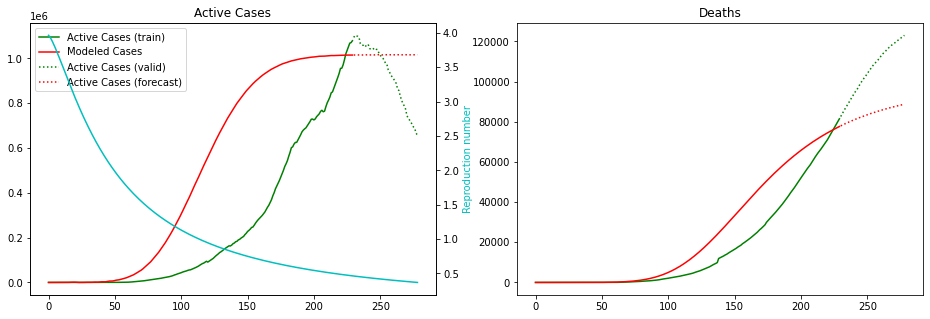

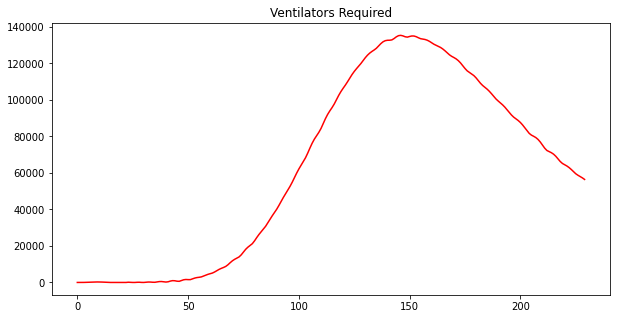

In [75]:
fit_model(N)

### As You can see From the Above Plots, This model makes a more accurate prediction of the Active Cases and Deaths 
### This is a relatively more accurate model since the validation MSLE(Mean Squared Logarithmic Error) is 0.059 only 
### And We don't even have to assume that 10% of all Infected people are Hospitalized. We can separately Predict the number of hospitalized/critical people using H,C of the SEIR_HCD Model
### Therefore, here we get a more accurate estimation of the number of ventilators India would have required till November to cater to all people who require it
### Conclusion -  India would need around 4,00,000 ventilators till the end of October

----------------